In [1]:
# Test the custom Nifti Dataset
import os
import torch
from omegaconf import OmegaConf

from configuration.files import LMDBDatasetConfig
from datasets.file_based import LMDBDataset
from utils.transforms import Cropper, Resize3D
from datasets.utils import instantiate_datasets
from datasets.mri import MRIDataset
from dataloaders.mri import MRIHoldoutDataLoader

In [3]:
CONFIG_FILE = "train/sfcnreg.yaml"

config = OmegaConf.load(CONFIG_FILE)

datasets = instantiate_datasets(config.datasets)

Selected datasets:
-- HCP1200 Dataset (Location: /work/preprocessing_alex_pipeline/lmdbs/HCP1200/volumes_T1w)
-- HCPAging Dataset (Location: /work/preprocessing_alex_pipeline/lmdbs/HCPAging/volumes_T1w)
-- FCON Dataset (Location: /work/preprocessing_alex_pipeline/lmdbs/FCON/volumes_T1w)


In [4]:
tfs = [Resize3D(config.train_config.img_shape, "trilinear")]

In [8]:
mri_dataloader = MRIHoldoutDataLoader(dataset=datasets, batch_size=4, num_workers=0, transforms=tfs)
mri_dataloader.setup()
train_mri_dataloader = mri_dataloader.val_dataloader() 

/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/torch/utils/data/dataset.py:473: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(


In [9]:
img : torch.Tensor
cond : torch.Tensor
img, cond = next(iter(train_mri_dataloader))
batch = (img, cond)

In [10]:
img.shape, cond.shape

(torch.Size([4, 1, 168, 192, 160]), torch.Size([4, 2]))

In [11]:
# To take only age
cond[:, 0]

tensor([28., 34., 23., 33.])

In [35]:
import matplotlib.pyplot as plt

def show_image(img, slice=65):
    # Visualize the mask
    
    plt.figure(figsize=(4, 4))
    plt.imshow(img[:,slice,...].cpu(), cmap="gray")
    plt.axis("off")
    plt.show()

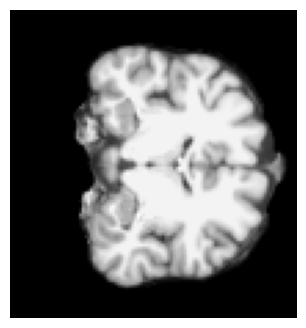

In [36]:
show_image(img[0, 0])

In [37]:
from model.sfcn_reg import RegressionSFCN

In [38]:
model = RegressionSFCN()

In [39]:
# model = model.to(mps_device)

In [40]:
model(img)

tensor([[3.]], grad_fn=<AddBackward0>)

In [11]:
import hydra
from omegaconf import OmegaConf

CONFIG_PATH = "/Users/kingpowa/Documents/Programming/pyment-public-torch/train/sfcnreg.yaml"
config = OmegaConf.load(CONFIG_PATH)

datasets = config.datasets
print(type(datasets))
inst_datasets = []

for dataset in datasets:
        print(type(dataset))
        inst_datasets.append(hydra.utils.instantiate(
            dataset
        ))

<class 'omegaconf.listconfig.ListConfig'>
<class 'omegaconf.dictconfig.DictConfig'>
<class 'omegaconf.dictconfig.DictConfig'>
<class 'omegaconf.dictconfig.DictConfig'>


In [12]:
datasets[0].keys()

dict_keys(['_target_', 'config'])

In [10]:
inst_datasets

In [41]:
from model.trainable_sfcn import SFCNModule

In [21]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

lightning_model = SFCNModule(model, learning_rate=0.1)

# Define the trainer
trainer = Trainer(
    max_epochs=2,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks=[ModelCheckpoint(monitor="val_loss", save_top_k=1)]
)

# Train the model
trainer.fit(lightning_model, datamodule=mri_dataloader)

NameError: name 'SFCNModule' is not defined